# Facies classification using Machine Learning & Deep learning

In [1]:
!git clone https://github.com/Ray4Rai/Lithofacies-Detection-And-Classification-Using-Well-Log-Data.git

Cloning into 'Lithofacies-Detection-And-Classification-Using-Well-Log-Data'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells, consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)


 

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import math
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.models import Sequential
from keras.layers import Dense,Softmax, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv('Lithofacies-Detection-And-Classification-Using-Well-Log-Data/facies_vectors.csv')
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [4]:
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [5]:
data=data.dropna()

In [6]:
data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels.

In [7]:
# 1=sandstone 2=c_siltstone 3=f_siltstone 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
                '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']
#facies_color_map is a dictionary which maps facies labels to their respective colors
facies_color_map = {}
for ind,label in enumerate(facies_labels):
    facies_color_map[label] =facies_colors[ind]
def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    

In [8]:
data



,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [9]:
data.loc[:,'FaciesLabels'] = data.apply(lambda row: label_facies(row, facies_labels), axis=1)
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


Let's take a look at the data from individual wells in a more familiar log plot form. We will create plots for the five well log variables, as well as a log for facies labels

In [10]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells. The function was written to take a list of colors and facies labels as parameters.

We then show log plots for wells SHRIMPLIN and SHANKLE.

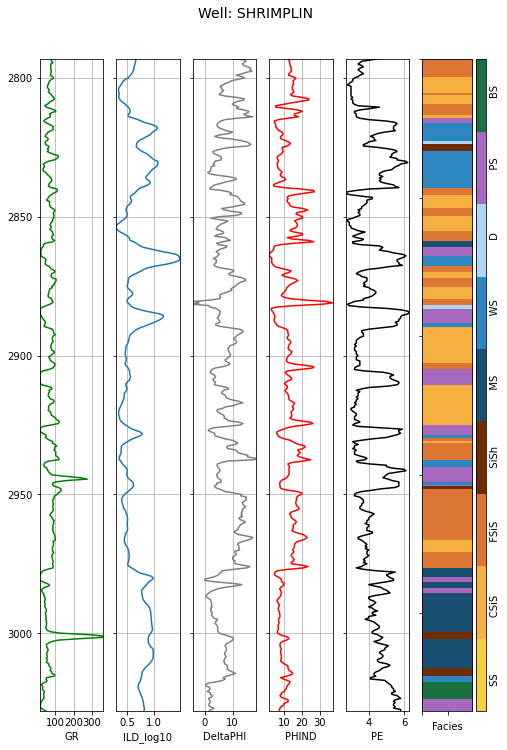

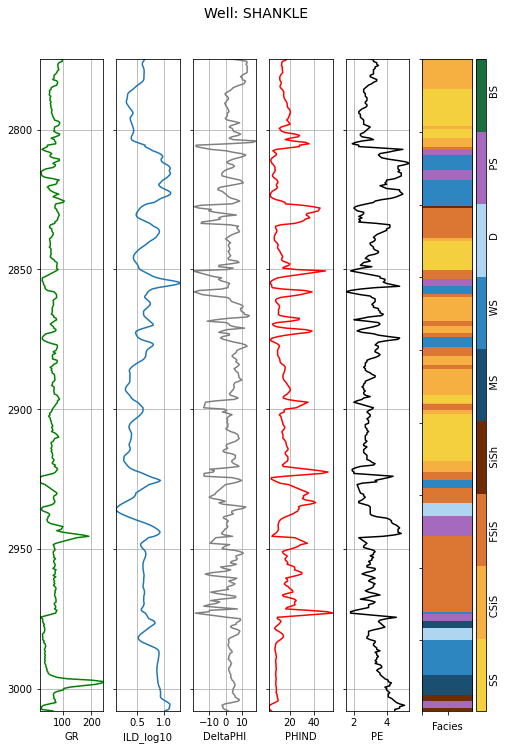

In [11]:
make_facies_log_plot(
    data[data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

make_facies_log_plot(
    data[data['Well Name'] == 'SHANKLE'],
    facies_colors)

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

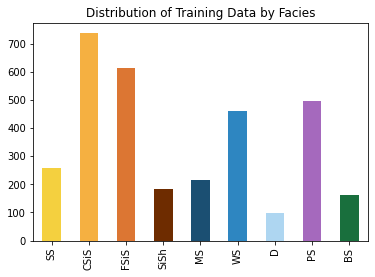

In [12]:
#In addition to individual wells, we can look at how the various facies are represented by the entire training set.
#Let's plot a histgram of the number of training examples for each facies class
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

facies_counts


This shows the distribution of examples by facies for the 3232 training examples in the training set.  Dolomite (facies 7) has the fewest with 98 examples.  There are also only 161 bafflestone examples.  Depending on the performance of the classifier we are going to train, we may consider getting more examples of these facies.

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset. We can employ the very useful Seaborn library to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap is used to represent the 9 facies.

/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


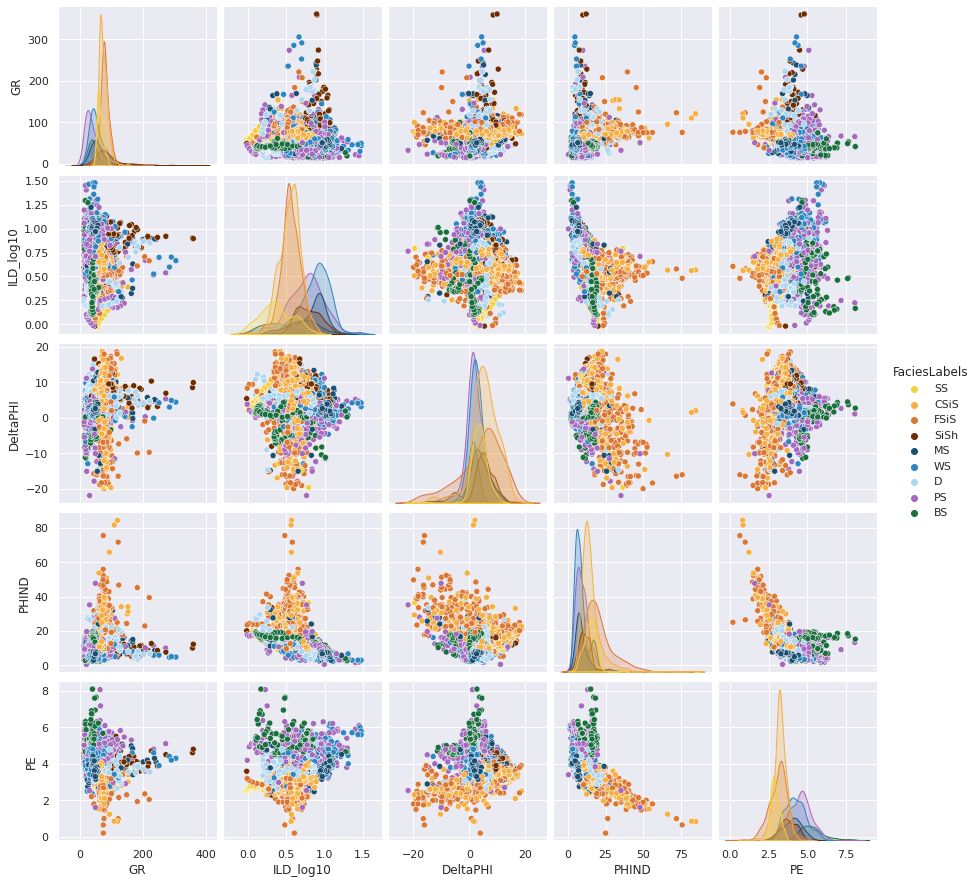

In [13]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(facies_labels))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification. 
The predictor variables are the five wireline values and two geologic constraining variables. 
We also get a vector of the facies labels that correspond to each feature vector.


In [14]:
output_cols = [data.Facies.name]
facies_labels = data[output_cols]

feature_vectors = data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [15]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [16]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


Scikit also includes a handy function to randomly split the training data into training and test sets. The test set contains a small subset of feature vectors that are not used to train the network. Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model. Let's use 20% of the data for the test set.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(feature_vectors, facies_labels, test_size=0.20, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(2585, 7)
(647, 7)
(2585, 1)
(647, 1)


In [19]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y_train)
Y_train=enc.transform(Y_train).toarray()
Y_test=enc.transform(Y_test).toarray()

## Start model

####Model_seq Architecture

In [20]:
model_seq = Sequential()
model_seq.add(layers.Dense(1024, activation = 'relu', input_shape =(X_train.shape[1],)))
model_seq.add(layers.Dense(512, activation = 'relu'))
model_seq.add(layers.Dense(512, activation ='relu'))
model_seq.add(layers.Dropout(0.4))
model_seq.add(layers.Dense(256,activation = 'relu'))
model_seq.add(layers.Dropout(0.4))
model_seq.add(layers.Dense(64,activation = 'relu'))
model_seq.add(layers.Dropout(0.4))
#model_seq.add(layers.Dense(9))
model_seq.add(layers.Dense(9,activation = 'softmax'))

In [21]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['acc']
)

In [22]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              8192      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                1

In [23]:
history = model_seq.fit(
          X_train,
          Y_train,
          epochs = 100,
          validation_data = (X_test,Y_test),
          batch_size = 64
  )

Epoch 1/100
41/41 [==============================] - 2s 9ms/step - loss: 2.3356 - acc: 0.1691 - val_loss: 1.9865 - val_acc: 0.1947
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 2.0141 - acc: 0.2344 - val_loss: 1.9760 - val_acc: 0.3586
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 1.8509 - acc: 0.3292 - val_loss: 1.5989 - val_acc: 0.4389
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 1.6660 - acc: 0.3791 - val_loss: 1.5150 - val_acc: 0.3740
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 1.5797 - acc: 0.3888 - val_loss: 1.4226 - val_acc: 0.4760
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 1.5029 - acc: 0.4112 - val_loss: 1.3921 - val_acc: 0.4683
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 1.4877 - acc: 0.4193 - val_loss: 1.3781 - val_acc: 0.4838
Epoch 8/100
41/41 [==============================] - 0s 5ms/step - loss: 1.4282 - a

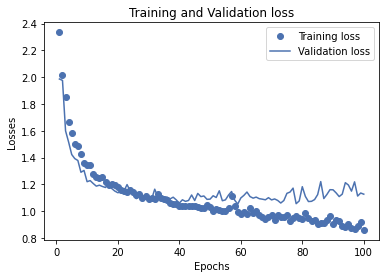

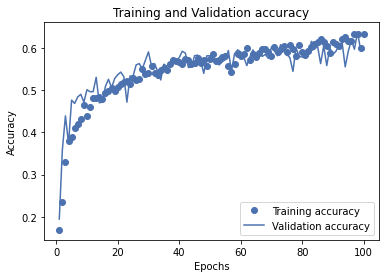

In [24]:
def model_plots(history):
  history_dict =history.history
  #plot histories

  epochs = history.epoch
  epochs = epochs[1:]
  epochs.append(len(epochs)+1)

  ## training loss and acc
  acc = history_dict['acc']
  loss= history_dict['loss']

  ##validation loss and acc
  val_acc = history_dict['val_acc']
  val_loss = history_dict['val_loss']

  plt.figure("losses")
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.legend()
  plt.title("Training and Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Losses")
  plt.show()

  plt.figure("Accuracy")
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.legend()
  plt.title("Training and Validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

model_plots(history)


In [25]:
X_train.shape[1],

(7,)

####Model_CNN Architecture

In [26]:
model_CNN = Sequential()
model_CNN.add(Conv1D(128, 2, activation="relu", input_shape=(X_train.shape[1],1)))
model_CNN.add(Dense(64, activation="relu"))
model_CNN.add(Dense(32, activation="relu"))
model_CNN.add(Dense(16, activation="relu"))
model_CNN.add(MaxPooling1D())
model_CNN.add(Flatten())
model_CNN.add(Dense(9, activation = 'softmax'))
model_CNN.compile(loss = 'categorical_crossentropy', 
     optimizer = "adam",               
              metrics = ['accuracy'])
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 128)            384       
                                                                 
 dense_6 (Dense)             (None, 6, 64)             8256      
                                                                 
 dense_7 (Dense)             (None, 6, 32)             2080      
                                                                 
 dense_8 (Dense)             (None, 6, 16)             528       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 16)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                      

In [27]:
history_CNN = model_CNN.fit(
          X_train,
          Y_train,
          epochs = 100,
          validation_data = (X_test,Y_test),
          batch_size = 64
  )

Epoch 1/100
41/41 [==============================] - 10s 35ms/step - loss: 2.0267 - accuracy: 0.2391 - val_loss: 1.9236 - val_accuracy: 0.2705
Epoch 2/100
41/41 [==============================] - 0s 11ms/step - loss: 1.9054 - accuracy: 0.2603 - val_loss: 1.8307 - val_accuracy: 0.2921
Epoch 3/100
41/41 [==============================] - 1s 12ms/step - loss: 1.7744 - accuracy: 0.3663 - val_loss: 1.6816 - val_accuracy: 0.4080
Epoch 4/100
41/41 [==============================] - 0s 9ms/step - loss: 1.6169 - accuracy: 0.3969 - val_loss: 1.5594 - val_accuracy: 0.4080
Epoch 5/100
41/41 [==============================] - 0s 9ms/step - loss: 1.5110 - accuracy: 0.4236 - val_loss: 1.4772 - val_accuracy: 0.3972
Epoch 6/100
41/41 [==============================] - 0s 9ms/step - loss: 1.4437 - accuracy: 0.4267 - val_loss: 1.4109 - val_accuracy: 0.4374
Epoch 7/100
41/41 [==============================] - 0s 9ms/step - loss: 1.3971 - accuracy: 0.4375 - val_loss: 1.3681 - val_accuracy: 0.4776
Epoch 8/1

In [28]:
def model_plots(history):
  history_dict =history.history
  #plot histories

  epochs = history.epoch
  epochs = epochs[1:]
  epochs.append(len(epochs)+1)

  ## training loss and acc
  acc = history_dict['accuracy']
  loss= history_dict['loss']

  ##validation loss and acc
  val_acc = history_dict['val_accuracy']
  val_loss = history_dict['val_loss']

  plt.figure("losses")
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.legend()
  plt.title("Training and Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Losses")
  plt.show()

  plt.figure("Accuracy")
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.legend()
  plt.title("Training and Validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()



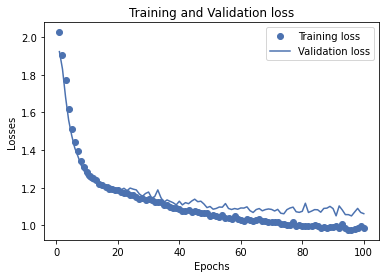

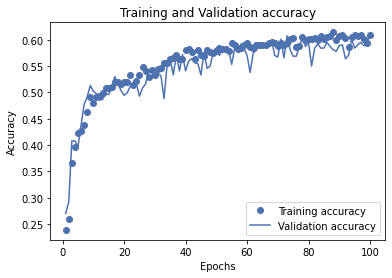

In [29]:
model_plots(history_CNN)

##XGB

In [30]:
from xgboost import XGBClassifier


In [31]:
Y_train=enc.inverse_transform(Y_train)
Y_test=enc.inverse_transform(Y_test)

In [32]:
model_XGB = XGBClassifier(max_depth=5,objective='multi:softprob',n_estimators=1000,num_classes=9)
history_XGB=model_XGB.fit(X_train, Y_train, early_stopping_rounds=300, eval_set=[(X_test, Y_test)], verbose=100)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-merror:0.386399
Will train until validation_0-merror hasn't improved in 300 rounds.
[100]	validation_0-merror:0.310665
[200]	validation_0-merror:0.304482
[300]	validation_0-merror:0.287481
[400]	validation_0-merror:0.285935
[500]	validation_0-merror:0.284389
[600]	validation_0-merror:0.285935
[700]	validation_0-merror:0.289026
Stopping. Best iteration:
[420]	validation_0-merror:0.281298



In [33]:
# make predictions for test data
Y_pred_XGB = model_XGB.predict(X_test)
predictions = [round(value) for value in Y_pred_XGB]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy))

Accuracy: 0.72%


###Unclassified data

In [35]:
import pandas as pd
well_data = pd.read_csv('Lithofacies-Detection-And-Classification-Using-Well-Log-Data/validation_data_nofacies.csv')



In [36]:
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911
...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556


In [37]:
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'],axis =1)

In [38]:
well_features.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807
std,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062
min,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000
25%,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000
50%,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500
75%,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000
max,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000


In [39]:
#scaler = preprocessing.StandardScaler().fit(well_features)
X_unknown = scaler.transform(well_features)

In [40]:
feature_vectors = data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


###Pedict facies of unclassified data





In [41]:

y_unknown_xgb = model_XGB.predict(well_features)
well_data['Facies XGB']=y_unknown_xgb

In [42]:
y_unknown_seq = model_seq.predict(well_features)
y_unknown_seq=enc.inverse_transform(y_unknown_seq)
well_data['Facies seq']=y_unknown_seq

In [43]:
y_unknown_CNN = model_CNN.predict(well_features)
y_unknown_CNN=enc.inverse_transform(y_unknown_CNN)
well_data['Facies CNN']=y_unknown_CNN

In [44]:
well_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies XGB,Facies seq,Facies CNN
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,2,2,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,3,3,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2,3,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2,3,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,3,3,2
826,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,3,3,2
827,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,3,3,2
828,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,3,3,2


In [45]:
well_data['Well Name'] = well_data['Well Name'].astype('category')

In [46]:
well_data['Well Name'].unique()

['STUART', 'CRAWFORD']
Categories (2, object): ['CRAWFORD', 'STUART']

In [47]:
def predict_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    

    cluster_XGB=np.repeat(np.expand_dims(logs['Facies XGB'].values,1), 100, 1)
    cluster_seq=np.repeat(np.expand_dims(logs['Facies seq'].values,1), 100, 1)
    cluster_CNN=np.repeat(np.expand_dims(logs['Facies CNN'].values,1), 100, 1)

    
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')

    im=ax[5].imshow(cluster_XGB, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')


    im=ax[6].imshow(cluster_seq, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')


    im=ax[7].imshow(cluster_CNN, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    num_facies_plot=3
    for i in range(len(ax)-num_facies_plot):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies XGB')
    ax[6].set_xlabel('Facies seq')
    ax[7].set_xlabel('Facies CNN')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[6].set_xticklabels([]); ax[7].set_xticklabels([])
  
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

    facies = {'SS':1, 'CSiS':2, 'FSiS':3, 'SiSh':4, 'MS':5, 'WS':6, 'D':7, 'PS':8, 'BS':9}
    hands =[]
    for k, col in zip(facies.keys(), facies_colors):
      hands.append(mpatches.Patch(color=col, label=k))
    plt.legend(handles=hands, loc=(2, 0.5), fontsize=18)  

In [48]:
x=well_data[well_data['Well Name'] == 'SHRIMPLIN']
print(x)

Empty DataFrame
Columns: [Formation, Well Name, Depth, GR, ILD_log10, DeltaPHI, PHIND, PE, NM_M, RELPOS, Facies XGB, Facies seq, Facies CNN]
Index: []


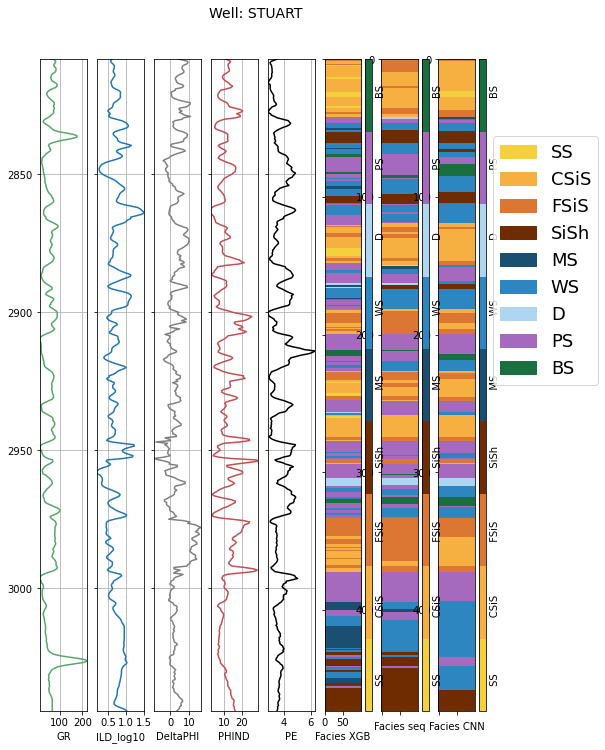

In [49]:
predict_facies_log_plot(well_data[well_data['Well Name'] == 'STUART'], facies_colors)

#labels = to_categorical(labels)

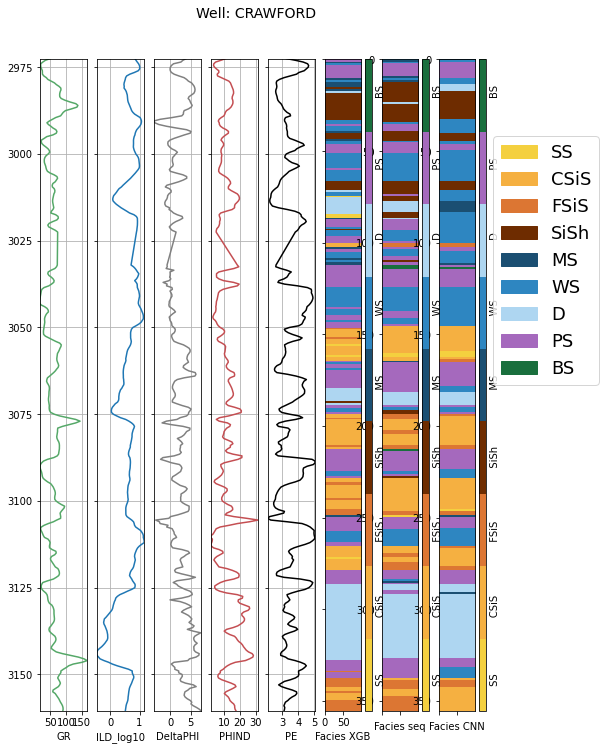

In [50]:
predict_facies_log_plot(well_data[well_data['Well Name'] == 'CRAWFORD'], facies_colors)

###Pedict facies of classified data

In [51]:
y_unknown_xgb = model_XGB.predict(feature_vectors)
data['Facies XGB']=y_unknown_xgb

In [52]:
y_unknown_seq = model_seq.predict(feature_vectors)
y_unknown_seq=enc.inverse_transform(y_unknown_seq)
data['Facies seq']=y_unknown_seq

In [53]:
y_unknown_CNN = model_CNN.predict(feature_vectors)
y_unknown_CNN=enc.inverse_transform(y_unknown_CNN)
data['Facies CNN']=y_unknown_CNN

In [54]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,Facies XGB,Facies seq,Facies CNN
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS,3,3,3
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS,3,3,3
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS,3,3,3
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS,3,3,3
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS,5,6,6
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS,5,6,6
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS,5,6,6
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS,5,6,6


In [55]:
def facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster_XGB=np.repeat(np.expand_dims(logs['Facies XGB'].values,1), 100, 1)
    cluster_seq=np.repeat(np.expand_dims(logs['Facies seq'].values,1), 100, 1)
    cluster_CNN=np.repeat(np.expand_dims(logs['Facies CNN'].values,1), 100, 1)

    
    f, ax = plt.subplots(nrows=1, ncols=9, figsize=(10, 14))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')

    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')



    im=ax[6].imshow(cluster_XGB, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')


    im=ax[7].imshow(cluster_seq, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')


    im=ax[8].imshow(cluster_CNN, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider = make_axes_locatable(ax[8])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    num_facies_plot=4
    for i in range(len(ax)-num_facies_plot):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('Facies XGB')
    ax[7].set_xlabel('Facies seq')
    ax[8].set_xlabel('Facies CNN')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[6].set_xticklabels([]); ax[7].set_xticklabels([])
    ax[8].set_xticklabels([])
  
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

    facies = {'SS':1, 'CSiS':2, 'FSiS':3, 'SiSh':4, 'MS':5, 'WS':6, 'D':7, 'PS':8, 'BS':9}
    hands =[]
    for k, col in zip(facies.keys(), facies_colors):
      hands.append(mpatches.Patch(color=col, label=k))
    plt.legend(handles=hands, loc=(2, 0.5), fontsize=18)  

In [56]:
data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,Facies XGB,Facies seq,Facies CNN
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS,3,3,3
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS,3,3,3
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS,3,3,3
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS,3,3,3
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS,5,6,6
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS,5,6,6
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS,5,6,6
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS,5,6,6


In [57]:
data['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

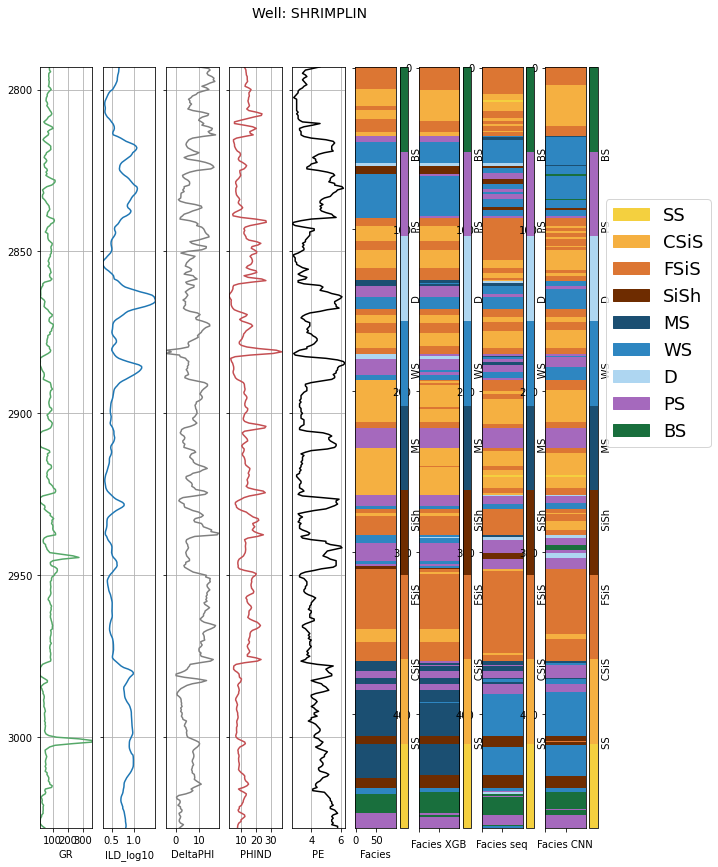

In [58]:
facies_log_plot(data[data['Well Name'] == 'SHRIMPLIN'], facies_colors)

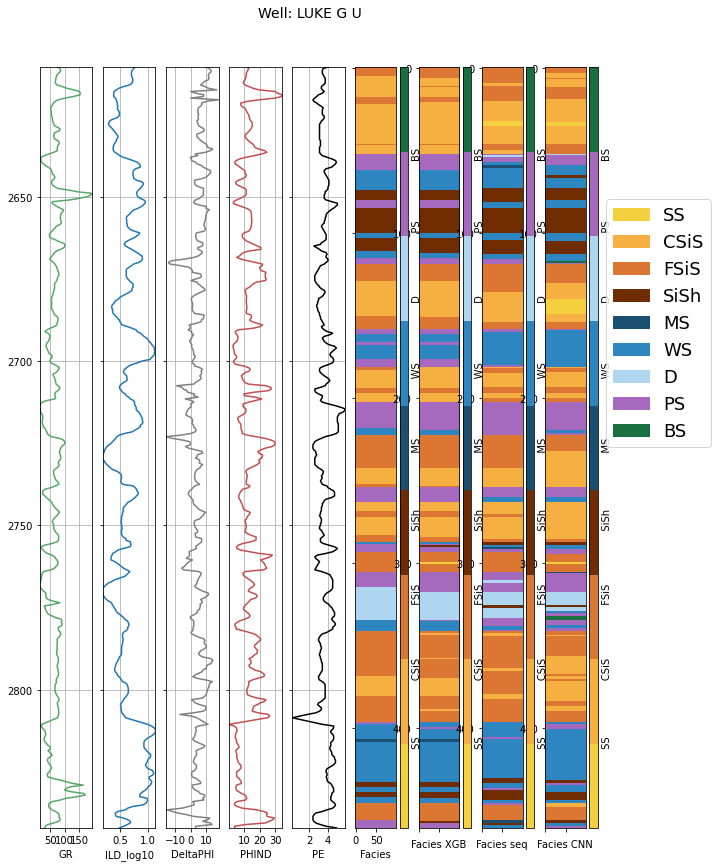

In [59]:
facies_log_plot(data[data['Well Name'] == 'LUKE G U'], facies_colors)